<a href="https://colab.research.google.com/github/Elangoraj/Social-network-analysis/blob/main/Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analyze a Network

**1.a) Load network**

In [150]:
# Import all libraries
import networkx as nx
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
from pylab import rcParams
import matplotlib.colors as mcolors#
import operator
import random as rd
!pip install powerlaw
import powerlaw
import community
from operator import itemgetter
import scipy.stats
import scipy.sparse
import scipy.sparse.csgraph
import warnings
warnings.filterwarnings("ignore")
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot, patches 
from scipy.stats import lognorm, kstest

In [151]:
# Load Network fropm drive
pwd = '/content/drive/MyDrive/Networks/ia-enron.csv'
fh = open(pwd, "rb")
Gx = nx.read_edgelist(fh, nodetype = int)
fh.close()

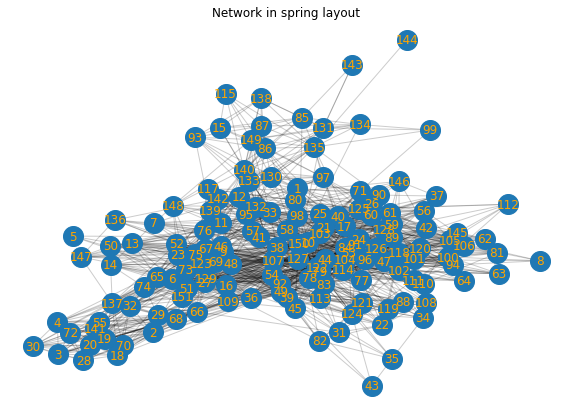

In [152]:
# Ia eron Network visualized in spring layout
plt.figure(figsize=(10,7))
pos = nx.spring_layout(Gx)
nx.draw_networkx_nodes(Gx, pos, node_size=400)
nx.draw_networkx_edges(Gx, pos = pos, alpha=0.2)
nx.draw_networkx_labels(Gx, pos, font_color='orange', font_family='sans-serif')
plt.axis('off')
plt.title('Network in spring layout')
plt.show()

**1.b) Adjacency Matrix**

Text(0, 0.5, 'nodes')

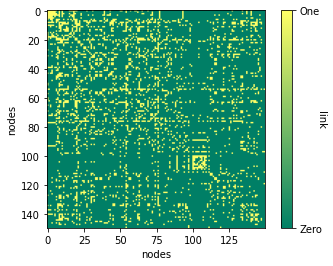

In [153]:
# Plot for the adjacency matrix
plt.imshow(nx.to_numpy_matrix(Gx), cmap='summer')
cbar = plt.colorbar()
cbar.set_ticks([0,1])
cbar.ax.set_yticklabels(['Zero','One'],)

cbar.set_label('link', rotation=270)
plt.xlabel('nodes')
plt.ylabel('nodes')

**1.c) Degree distribution**

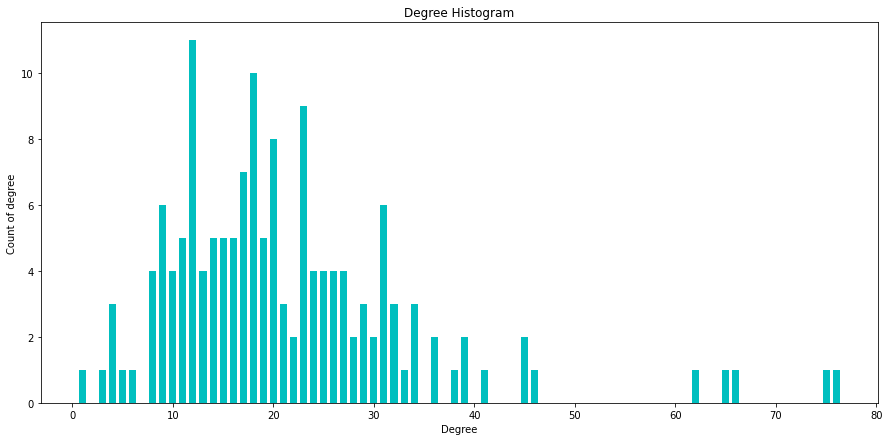

In [154]:
# Find the degree distribution across nodes
degree_sequence = sorted([d for n, d in Gx.degree()], reverse=True) 
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())                                       
 
# Bar plot 
plt.figure(figsize=(15,7))
plt.bar(deg, cnt, width=0.70, color='c') 
plt.title("Degree Histogram")
plt.ylabel("Count of degree")
plt.xlabel("Degree")
plt.show()

**1.d) Kolomoropv-Smirnov test**

In [155]:
# Find the lognorm for the degree distribution 
dc = list(degreeCount.values())
sigma, loc, scale = lognorm.fit(dc, floc=0)
mu = np.log(scale)

print("mu    = %9.5f" % mu)
print("sigma = %9.5f" % sigma)

# Using kstest for stats library find the p value 
stat, p = kstest(dc, 'lognorm', args=(sigma, 0, scale))
print("KS Test:")
print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)

mu    =   0.97465
sigma =   0.76074
KS Test:
stat    =   0.20226
p-value =   0.05103


**1.e) Assortative or Disassortative**

Text(0.5, 1.0, 'Degree-Degree scatter plot')

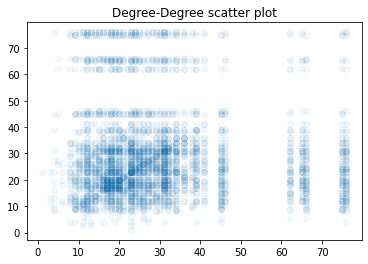

In [156]:
x = []
y = []

for i,j in Gx.edges():
  x.append(Gx.degree(i))
  y.append(Gx.degree(j))
  x.append(Gx.degree(j))
  y.append(Gx.degree(i))

# https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/Book%3A_Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems_(Sayama)/17%3A_Dynamical_Networks_II__Analysis_of_Network_Topologies/17.06%3A_Assortativity
plt.plot(x,y,'o',alpha=0.05)
plt.title('Degree-Degree scatter plot')

In [157]:
assortativity = nx.degree_assortativity_coefficient(Gx)
print('Assortativity of the network =', assortativity)

Assortativity of the network = -0.04538787508087504


**1.f) Fitting**

alpha=  4.21041781199002   sigma=  0.7365203583688135


Calculating best minimal value for power law fit


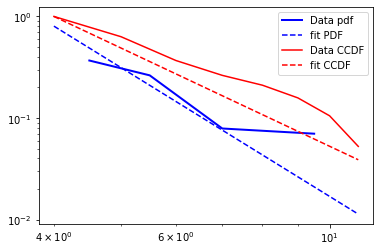

In [158]:
# Find the fit for the degree count in the data
dcf = list(degreeCount.values())
plf = powerlaw.Fit(dcf)

# PDF
pt=plf.plot_pdf(color='b', linewidth=2)
plf.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf',ax = pt)

# CCDF
plf.plot_ccdf(color= 'r',ax = pt)
plf.power_law.plot_ccdf( color= 'r',linestyle='--',label='fit ccdf',ax = pt)

print('alpha= ',plf.power_law.alpha,'  sigma= ',plf.power_law.sigma)

plt.legend(['Data pdf', 'fit PDF', 'Data CCDF', 'fit CCDF'])
plt.show()

# **2. Centrality and Community Detection**

**2.a) Centralities**

**Degree centralities:** Degree centrality defined as measurement of the number of connections owned by a node. The higher the degree, the more central the node is. Depends on the direction of the network two seperate measures of degree centrality are defined, indegree and outdegree. Count of incoming ties is the indegree and count of outgoing ties is the outdegree.

Example: Finding popular person within the class in twitter, in medical science to find degree of protein, etc.

**Eigenvector centrality:** It is measures a node’s importance while giving consideration to the importance of its neighbors. Here a node with few connections could have high eigenvector centrality if those few connections were to very well-connected nodes.

Example: Finding Influential person in the country, key author in reseach, impactful people on social media, etc.

**Difference between Degree and Eigenvector centrality:** Degree centrality awards one centrality point for every link to the node. But in eigenvector centrality a node is important if it is linked to by another important nodes. Degree centrality gives the number of relationship degree conected to the node whereas enigenvector gives the influential node in the network. In Eigenvector centrality a node receiving many links does not necessarily have a high eigenvector centrality and a node with high eigenvector centrality is not necessarily highly linked which is opposite way of degree centrality. 

**When to apply:** Usually degree centrality is used when finding highly connected, popular individual, node which can quickly connect to wider network and one which holds most information in the network. Eigenvector is used to understand human social network and understanding networks like malware propogation.  

**2.b.i) Closeness centrality**

In [159]:
# Clossness centrality of the graph (total_nodes-1)/total_shortest_length_of_node
cl_ce = {}
for i in (Gx.nodes()):
  tol = sum(list(dict(nx.all_pairs_shortest_path_length(Gx))[i].values()))
  cl_ce[i] = (len(Gx.nodes())-1)/tol

In [160]:
print('Closeness centrality of the nodes', cl_ce)

Closeness centrality of the nodes {48: 0.5418181818181819, 13: 0.4806451612903226, 67: 0.49174917491749176, 75: 0.5283687943262412, 147: 0.4501510574018127, 50: 0.44610778443113774, 38: 0.5601503759398496, 49: 0.5498154981549815, 107: 0.6208333333333333, 54: 0.5457875457875457, 27: 0.5302491103202847, 96: 0.5498154981549815, 151: 0.5016835016835017, 66: 0.5265017667844523, 129: 0.5379061371841155, 136: 0.3983957219251337, 142: 0.43440233236151604, 137: 0.4837662337662338, 76: 0.48220064724919093, 44: 0.5437956204379562, 122: 0.645021645021645, 139: 0.49174917491749176, 69: 0.5340501792114696, 114: 0.4983277591973244, 81: 0.4584615384615385, 125: 0.5033783783783784, 61: 0.5173611111111112, 39: 0.5137931034482759, 58: 0.49174917491749176, 32: 0.48220064724919093, 128: 0.5379061371841155, 91: 0.4983277591973244, 59: 0.5246478873239436, 19: 0.4318840579710145, 20: 0.40821917808219177, 63: 0.44744744744744747, 2: 0.476038338658147, 141: 0.436950146627566, 89: 0.4837662337662338, 57: 0.51557

**2.b.ii) Comparison Centralities**

In [161]:
# Find the eigenvector centrality for the graph
eg_ce = nx.eigenvector_centrality(Gx)

Correlation value between closness and eigen vector centrality = 0.9250810688678448


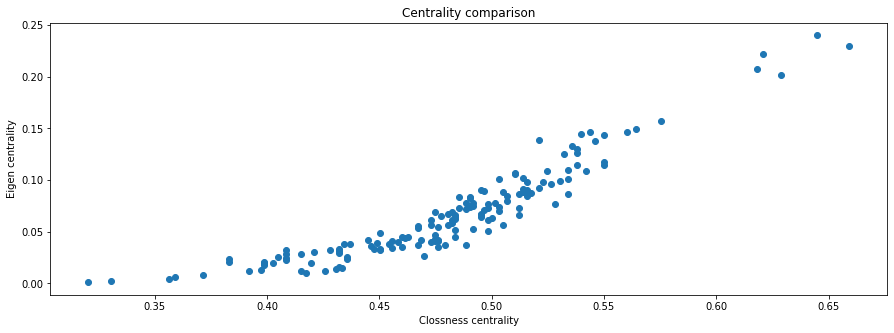

In [162]:
# Plot the graph to compare centrality
print('Correlation value between closness and eigen vector centrality =',scipy.stats.pearsonr(list(cl_ce.values()),list(eg_ce.values()))[0])

plt.figure(figsize=(15,5))
plt.title('Centrality comparison')
plt.scatter(cl_ce.values(),eg_ce.values())
plt.xlabel('Clossness centrality')
plt.ylabel('Eigen centrality')
plt.show()

**2.c) Centrality measure**

In [163]:
# Find the node with with highest eigenvector centrality 
eg_ce = nx.eigenvector_centrality(Gx)
max_eg_ce = max(eg_ce.items(), key=operator.itemgetter(1))
print('Node which is more influential =', max_eg_ce[0])
print('Eigenvector value for the node =', max_eg_ce[1])

Node which is more influential = 122
Eigenvector value for the node = 0.23999231568820278


In [164]:
def plot_influential_node(G,plot_graph):

  # Find the eigenvector centrality
  eg_ce = nx.eigenvector_centrality(G)

  print('Node which is more influential =',max(eg_ce.items(), key=operator.itemgetter(1))[0])
  print('Eigenvector value for the node =',max(eg_ce.items(), key=operator.itemgetter(1))[1])

  # Plot the graph with node color representing the eigen values
  if plot_graph==True:
    plt.figure(figsize=(15,10))
    pos = nx.spring_layout(G)

    nodes = nx.draw_networkx_nodes(G, pos, node_size=200, cmap='Greys', node_color=list(eg_ce.values()), nodelist=list(eg_ce.keys())) 

    max_node  = list(eg_ce.keys())[max(enumerate(eg_ce.values()), key=operator.itemgetter(1))[0]]

    nx.draw_networkx_nodes(Gx, pos, node_size=700, node_color ='black', nodelist=nx.shortest_path(G,source=max_node,target=max_node)) 

    labels = nx.draw_networkx_labels(G, pos, font_color='white')
    edges = nx.draw_networkx_edges(G, pos, alpha = 0.2)

    cbar = plt.colorbar(nodes) 

    cbar.set_label('Eigenvector centrality     ', rotation=270) 
    plt.axis('off')
    plt.show()

  return max(eg_ce.items(), key=operator.itemgetter(1))[0]

Node which is more influential = 122
Eigenvector value for the node = 0.23999231568820278


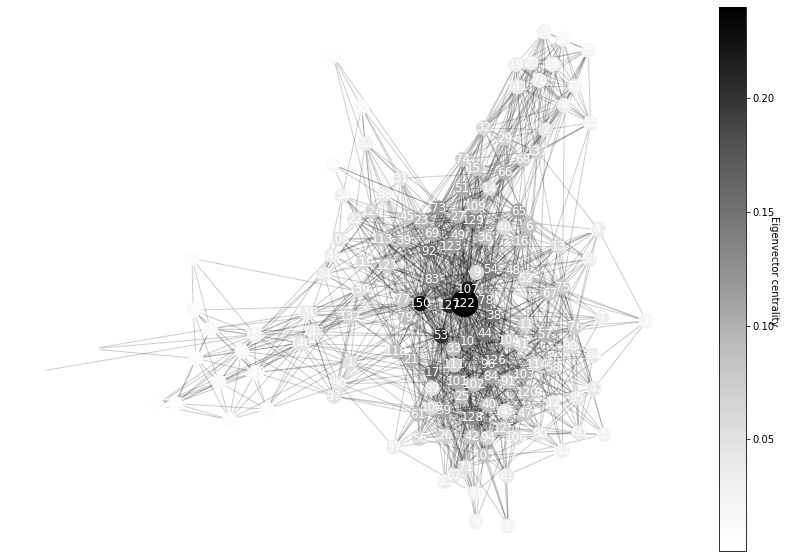

In [165]:
influential_node = plot_influential_node(Gx,True)

**2.d) Influencer**

In [166]:
def Draw_ego_network(G, node_id, max_distance):
  
  # Find the ego network for the node id given
  n_id = node_id
  hub_ego = nx.ego_graph(G, n_id, distance= 'weight')
  clusters=np.array(list(set(dict(hub_ego.degree).values())))
  
  # Find the sets out of the clusters 
  length=dict(nx.all_pairs_shortest_path_length(G,cutoff=max_distance))
  measures= length[n_id]
  clusters = np.array(list(set(measures.values())))

  # Set the size for each node based on the group it belongs to
  mv = list(measures.values())
  size = []
  for i in range(0,len(mv)):
    if mv[i] == 0: size.append(400) 
    elif mv[i] == 1: size.append(100)
    elif mv[i] == 2: size.append(50)
    else: size.append(20)

  # Set the graph from the ego network values
  plt.figure(figsize=(15,10))
  pos = nx.spring_layout(G)
  edges = nx.draw_networkx_edges(G, pos, edge_cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), alpha=0.1)
  nodes = nx.draw_networkx_nodes(G, pos, node_size=size, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), node_color=list(measures.values()), nodelist=list(measures.keys()))
 
  # Color bar plot
  cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Degree')
  cb.ax.tick_params(length=0)
  cb.set_ticklabels(list(set(measures.values())))
  nodes.set_clim(-0.5, len(clusters)-0.5)
  plt.axis('off')
  plt.show()


Node which is more influential = 122
Eigenvector value for the node = 0.23999231568820278


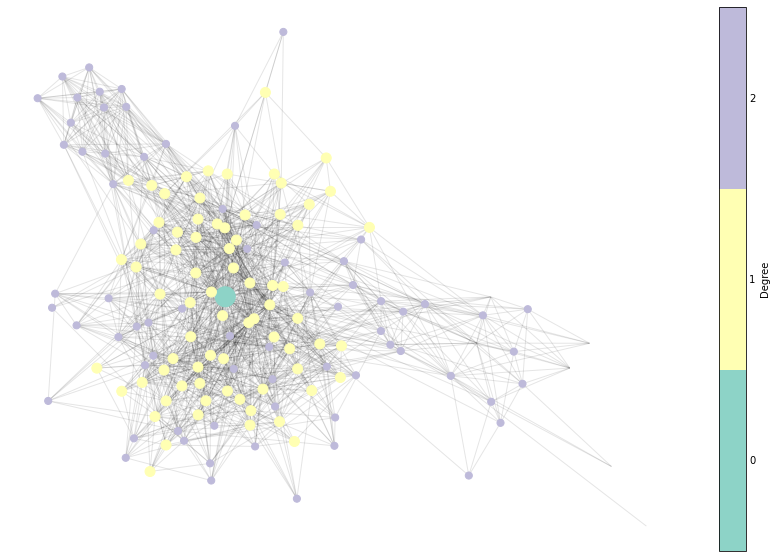

In [167]:
max_distance = 2
node_id = plot_influential_node(Gx,False)
Draw_ego_network(Gx, node_id, max_distance)

**(2.e) Community Detection and Centrality**

In [168]:
def community_detection(G):

  # Find the best partition
  bp = community.best_partition(G)
  ov = []
  for k, v in (Counter(bp.values())).items():
    ov.append([k,v])

  ov = sorted(ov, key=operator.itemgetter(1), reverse=True)
  nov = [k[0] for k in ov]

  tx = {}
  for i, j in bp.items():
    tx[i] = nov.index(j)

  lo = defaultdict(list)
  for i, j in tx.items():
    lo[j].append(i)

  lo = lo.values()

  # Plot the adjacency matrix  
  loc = [n for c in lo for n in c]
  adj = nx.to_numpy_matrix(G, nodelist=loc)
  plt.matshow(adj,interpolation=None, cmap = plt.cm.Blues)
  plt.colorbar(label='Link')

  split = [lo]
  colours = ['r']

  ax = plt.gca()

  # Plot the red boxes based on partitions
  for split, color in zip(split, colours):
    idx = 0 
    for m in split:
      ax.add_patch(patches.Rectangle((idx,idx),len(m),len(m),facecolor="none", edgecolor = color,linewidth="2"))
      idx += len(m)

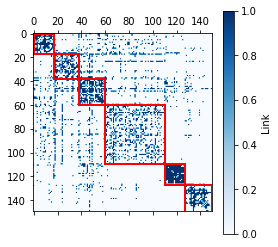

In [169]:
# Community detection function call  
community_detection(Gx)

In [170]:
def draw_clu(G, pos, measures, measure_name):

  # Set figure size
  plt.figure(figsize=(10,7))

  # Best partition set of groups
  clusters=np.array(list(set(measures.values())))

  # Plot the nodes based on the graph and groups
  nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), node_color=list(measures.values()), nodelist=list(measures.keys()))

  # Use label from networkx for identifying nodes
  labels = nx.draw_networkx_labels(G, pos)

  # Control the edges connecting the nodes
  edges = nx.draw_networkx_edges(G, pos, alpha=0.3)

  # Plot parameters 
  plt.title(measure_name)
  cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Communities')
  cb.ax.tick_params(length=0)
  cb.set_ticklabels(list(set(measures.values())))
  nodes.set_clim(-0.5, len(clusters)-0.5)
  plt.axis('off')
  plt.show()

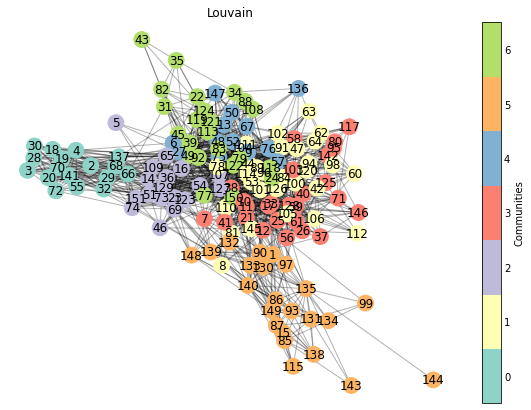

In [171]:
# Define the parameters 
pos = nx.spring_layout(Gx)
measure = community.best_partition(Gx)
measure_name = 'Louvain'

# Call the function
draw_clu(Gx, pos, measure, measure_name)

**2.f) Longest Shortest Path**

In [172]:
def plot_long_shortest(G):

  # Find all the shortest path of all nodes
  path = dict(nx.all_pairs_shortest_path_length(G))

  # Find the max path among the all possible shortest path for each node
  max_path = []
  for i in (list(path.keys())):
    max_path.append((i,max(path[i].items(), key=operator.itemgetter(1))[0],max(path[i].items(), key=operator.itemgetter(1))[1]))

  # Pick one of the longest shortest path within the above list max_path
  source=max(max_path,key=itemgetter(2))[0] 
  target=max(max_path,key=itemgetter(2))[1]

  # Define the network layout 
  pos = nx.spring_layout(G)

  # Define the nodes and edges for the complete graph
  nx.draw_networkx_nodes(G,pos,node_color='k',node_size=30, label=True)
  nx.draw_networkx_edges(G, pos, alpha=0.1)

  # Find shortest path between our source and target nodes
  path = nx.shortest_path(G,source=source,target=target)
  print('One of the longest shortest path in the Network:',path)

  # Plot this path over the overall graph 
  path_edges = list(zip(path,path[1:]))
  nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='g', label=True, node_size=200)
  nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='g',width=7)
  nx.draw_networkx_labels(G,pos,labels=dict(zip(path,path)), font_color='w', font_size = 8)
  plt.axis('off')
  plt.show()

One of the longest shortest path in the Network: [151, 66, 53, 135, 144]


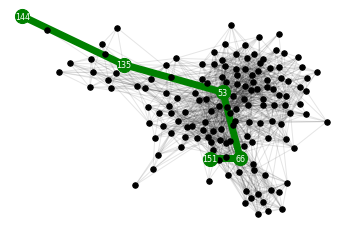

In [173]:
# Function call
plot_long_shortest(Gx)

# 3) SI Model

**3.a) SI Model**

In [174]:
def SI_model(G, initial_infecteds , beta, t_simulation):

  # Initialize parameters 
  initialNodesInfected = initial_infecteds
  population = len(Gx.nodes()) 
  recoveryTime = 15 
  
  # Declare the empty lists
  sData = []  # susceptible data
  infectedData = []  # infected data
  timeList = []  # time data (0 to time)

  # Function for finding neighbours and infected nodes
  def getInfected(graph):
      return [x for x,y in graph.nodes(data=True) if y['infected'] == 1 and y['recovered'] == False]

  def getNeighbors(graph, givenNode):
      return [x for x in graph.neighbors(givenNode)]

  # accessing nodes
  nodes = G.nodes()

  # setting initial conditions
  for node in nodes:
    if int(node) in initialNodesInfected:
        G.nodes[node]['infected'] = True
    else:
        G.nodes[node]['infected'] = False
    G.nodes[node]['recovered'] = False
    G.nodes[node]['recoveryTime'] = 0

  # Iterate for t_simulation
  for t in range(t_simulation):
    # adding the time t
    timeList.append(t)

    # infecting nodes
    infected = getInfected(G)
    for j in infected:
        neighbors = getNeighbors(G, j)
        for n in neighbors:
            rand = rd.random()
            if rand <= beta:
                G.nodes[n]['infected'] = True

    # Append all results
    infected = getInfected(G)
    infectedData.append(len(infected))
    sData.append(population - len(infected))
    
    pos = nx.spring_layout(G)

    # Plot the simulation at multiple checkpoints in the graph 
    if t in (2,30,50):
      color_map = []
      for iteration in (list(G.nodes())):
          color_map.append('green')
      print('Day number =',t)
      print('Infected =',len(infected))
      for i in (infected):
        if int(i)<116:  color_map[int(i)-1] = 'red'
        else:   
          color_map[int(i)-2] = 'red'

      nx.draw(G, pos, node_color=color_map, with_labels=True)
      plt.show()

  # Plot the graph 
  plt.title('SI Model')
  plt.plot(timeList, sData, label="Susceptible", color = 'g')
  plt.plot(timeList, infectedData, label="Infected", color='r')
  plt.legend()
  plt.show()

  return sData, infectedData


Day number = 2
Infected = 14


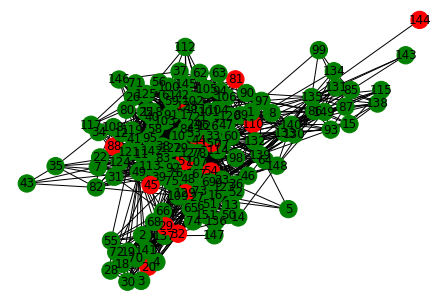

Day number = 30
Infected = 100


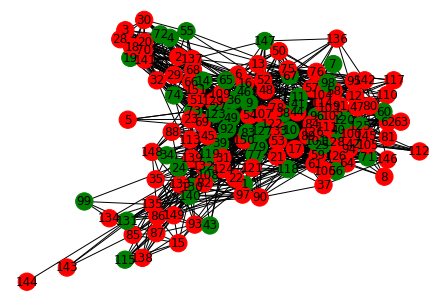

Day number = 50
Infected = 132


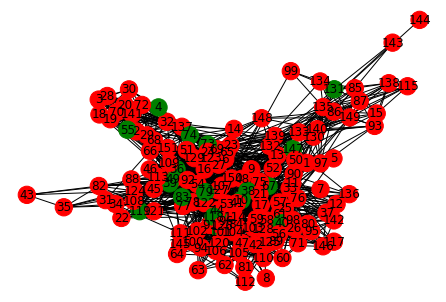

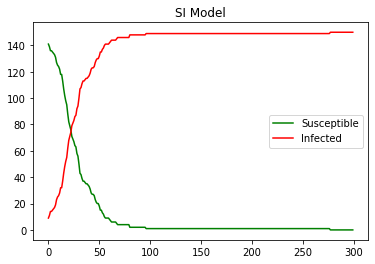

In [175]:
# Define parameters
initial_infecteds = [10,15,20,25,30,35,40,45]
beta = 0.005
t_simulation = 300

# SI model function call
SI_Suscetible, SI_Infected = SI_model(Gx, initial_infecteds , beta, t_simulation)

**3.b) SIR Model**

In [176]:
def SIR_model(G, initial_infecteds , beta, t_simulation, recoveryTime):
  
  # Initialize parameters 
  population = len(Gx.nodes())  # how many nodes
  initialNodesInfected = initial_infecteds  

  # Declare the empty lists
  sData = []  # susceptible data
  sData_SIR = []
  infectedData = []  # infected data
  recoveredData = [] 
  timeList = []  # time data (0 to time)
  
  # Function for finding neighbours, recovered and infected nodes
  def getInfected(graph):
      return [x for x,y in graph.nodes(data=True) if y['infected'] == 1 and y['recovered'] == False]

  def getNeighbors(graph, givenNode):
      return [x for x in graph.neighbors(givenNode)]
  
  def getRecovered(graph):
    return [x for x,y in graph.nodes(data=True) if y['recovered'] == True]

  # switch between the three graphs
  graphToUse = G

  # accessing nodes
  nodes = G.nodes()

  # initial_infecteds_nodes = random.sample(list(G.nodes()),initial_infecteds)

  # initialNodesInfected = []
  # for r in range(len(initial_infecteds_nodes)):
  #   initialNodesInfected.append(int(initial_infecteds_nodes[r]))

  # setting initial conditions
  for node in nodes:
    if int(node) in initialNodesInfected:
        G.nodes[node]['infected'] = True
    else:
        G.nodes[node]['infected'] = False
    G.nodes[node]['recovered'] = False
    G.nodes[node]['recoveryTime'] = 0

  # Iterate for t_simulation
  for t in range(t_simulation):
    
    # adding the time t
    timeList.append(t)

    # infecting nodes
    infected = getInfected(G)
    for j in infected:
        neighbors = getNeighbors(G, j)
        for n in neighbors:
            rand = rd.random()
            if rand <= beta:
                G.nodes[n]['infected'] = True

    # Recovery condition
    for k in infected:

      if G.nodes[k]['recoveryTime'] >= recoveryTime:
        G.nodes[k]['recovered'] = True
      G.nodes[k]['recoveryTime'] += 1
     
    # Append all results
    infected = getInfected(G)
    infectedData.append(len(infected))
    recovered = getRecovered(G)
    recoveredData.append(len(recovered))
    sData.append(population - len(infected))
    sData_SIR.append(population - len(infected) - len(recovered))

    pos = nx.spring_layout(G)

    # Plot the simulation at multiple checkpoints in the graph 
    if t in (2,30,50):
      color_map = []
      for iteration in (list(G.nodes())):
          color_map.append('b')
      print('Day number =',t)
      print('Infected node count =',len(infected))
      print('Recovered node count =',len(recovered))
      for i in (infected):
        if int(i)<116:  color_map[int(i)-1] = 'r'
        else:   
          color_map[int(i)-2] = 'r'
      for i in (recovered):
        if int(i)<116:  color_map[int(i)-1] = 'g'
        else:   
          color_map[int(i)-2] = 'g'

      nx.draw(G, pos, node_color=color_map, with_labels=True,alpha = 0.2)
      plt.show()

  # Plot the outputs of the models for t_simulations  
  plt.title('SIR Model')
  plt.plot(timeList, sData_SIR, label="SIR Suscetible")
  plt.plot(timeList, infectedData, label="SIR Infected", color='r')
  plt.plot(timeList, recoveredData, label="SIR Recovered")
  plt.legend()
  plt.show()

  # Data output
  return sData_SIR, infectedData, recoveredData


Day number = 2
Infected node count = 3
Recovered node count = 0


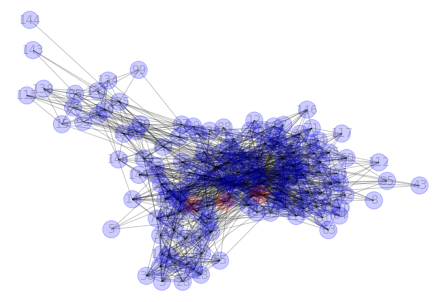

Day number = 30
Infected node count = 6
Recovered node count = 7


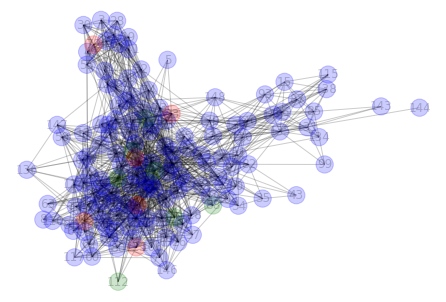

Day number = 50
Infected node count = 7
Recovered node count = 16


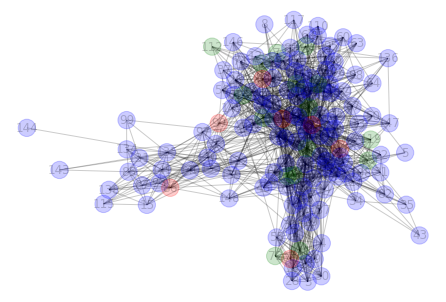

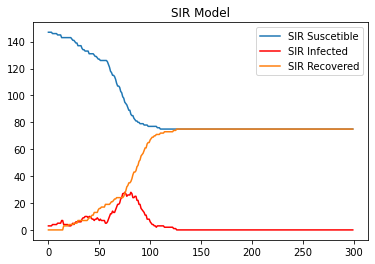

In [177]:
# Define parameters
initial_infecteds = [10,15,20]
beta = 0.005
t_simulation = 300
recoveryTime = 15

# SIR model function call
SIR_Suscetible, SIR_infected, SIR_recovered = SIR_model(Gx, initial_infecteds , beta, t_simulation, recoveryTime)

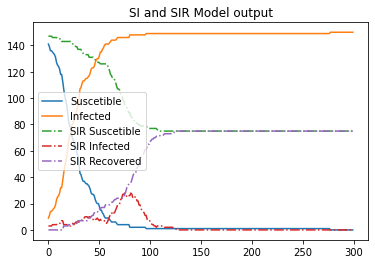

In [178]:
# Plot and compare SI and SIR model outputs as lineplot 
timeList = np.arange(0,t_simulation)
plt.title('SI and SIR Model output')
plt.plot(timeList, SI_Suscetible, label="Suscetible")
plt.plot(timeList, SI_Infected, label="Infected")
plt.plot(timeList, SIR_Suscetible, label="SIR Suscetible", linestyle='-.')
plt.plot(timeList, SIR_infected, label="SIR Infected", linestyle='-.')
plt.plot(timeList, SIR_recovered, label="SIR Recovered", linestyle='-.')
plt.legend()
plt.show()

In [179]:
def Second_wave(G, initial_infecteds , beta, t_simulation, recoveryTime, new_infections):

  # Initialize parameters 
  population = len(Gx.nodes())  # how many nodes
  beta = beta  
  initialNodesInfected = initial_infecteds

  # Define all empty lists
  sData = []  # susceptible data
  sData_SIR = []
  infectedData = []  # infected data
  recoveredData = [] 
  timeList = []  # time data (0 to time)

  # Function for finding neighbours, recovered and infected nodes
  def getInfected(graph):
      return [x for x,y in graph.nodes(data=True) if y['infected'] == 1 and y['recovered'] == False]

  def getNeighbors(graph, givenNode):
      return [x for x in graph.neighbors(givenNode)]
  
  def getRecovered(graph):
    return [x for x,y in graph.nodes(data=True) if y['recovered'] == True]

  # accessing nodes
  nodes = G.nodes()

  # setting initial conditions
  for node in nodes:
    if int(node) in initialNodesInfected:
        G.nodes[node]['infected'] = True
    else:
        G.nodes[node]['infected'] = False
    G.nodes[node]['recovered'] = False
    G.nodes[node]['recoveryTime'] = 0

  # Iterate through for t_simulations
  for t in range(t_simulation):
    timeList.append(t)
    if t<100:

      # infecting nodes
      infected = getInfected(G)
      for j in infected:
          neighbors = getNeighbors(G, j)
          for n in neighbors:
              rand = rd.random()
              if rand <= beta:
                  G.nodes[n]['infected'] = True

      # Check for recovery of the infected nodes
      for k in infected:
        if G.nodes[k]['recoveryTime'] >= recoveryTime:
          G.nodes[k]['recovered'] = True
        G.nodes[k]['recoveryTime'] += 1

    # Chenge in working after second wave
    elif t>=100:
      infected = getInfected(G)

      # Second wave effect in 100th day
      if t == 100:
        sus = []

        # Find susceptible nodes and apply second wave conditions
        for i in G.nodes():
          if G.nodes[i]['infected']==False: # (G.nodes[i]['infected']==True and G.nodes[i]['recovered']==True) or
            sus.append(i)
        if new_infections > len(sus):
          new_infected_nodes = random.sample(sus,len(sus))
        else:  
          new_infected_nodes = random.sample(sus,new_infections)
        new_infected = []
        for r in range(len(new_infected_nodes)):
          new_infected.append(int(new_infected_nodes[r]))

        # setting new infection conditions for susceptible nodes
        for node in nodes:
          if int(node) in new_infected:
              G.nodes[node]['infected'] = True
              G.nodes[node]['recovered'] = False
              G.nodes[node]['recoveryTime'] = 0

        # Set 0 recovery for infected nodes
        for k in infected:
          G.nodes[k]['recoveryTime'] = 0
        
      # Apply neighbour conditions
      for j in infected:
        neighbors = getNeighbors(G, j)
        for n in neighbors:
            rand = rd.random()
            if rand <= beta:
                G.nodes[n]['infected'] = True

      # Set recovery conditions 
      for k in infected:
        if G.nodes[k]['recoveryTime'] >= recoveryTime:
          G.nodes[k]['recovered'] = True
        G.nodes[k]['recoveryTime'] += 1

    # Append all the outputs 
    infected = getInfected(G)
    infectedData.append(len(infected))
    recovered = getRecovered(G)
    recoveredData.append(len(recovered))
    sData.append(population - len(infected))
    sData_SIR.append(population - len(infected) - len(recovered))

  # Plot the outputs in the form of a graph
  plt.title('Second Wave')
  plt.plot(timeList, sData_SIR, label="SW Suscetible")
  plt.plot(timeList, infectedData, label="SW Infected")
  plt.plot(timeList, recoveredData, label="SW Recovered")
  plt.legend()
  plt.show()

  # Return the data output 
  return sData_SIR, infectedData, recoveredData


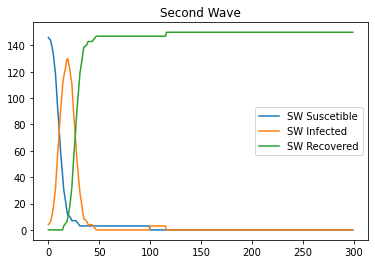

In [180]:
# Parameter inputs
initial_infecteds = [10,15,20]
beta = 0.02
t_simulation = 300
recoveryTime = 15
new_infections = 30

# Function call for scecond wave
SW_Suscetible, SW_infected, SW_recovered = Second_wave(Gx, initial_infecteds , beta, t_simulation, recoveryTime, new_infections)

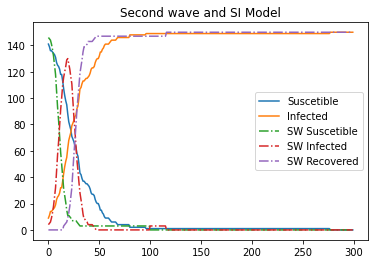

In [181]:
# Plot second wave against SI model
timeList = np.arange(0,t_simulation)
plt.title('Second wave and SI Model')
plt.plot(timeList, SI_Suscetible, label="Suscetible")
plt.plot(timeList, SI_Infected, label="Infected")
plt.plot(timeList, SW_Suscetible, label="SW Suscetible", linestyle='-.')
plt.plot(timeList, SW_infected, label="SW Infected", linestyle='-.')
plt.plot(timeList, SW_recovered, label="SW Recovered", linestyle='-.')
plt.legend()
plt.show()

In [182]:
Gx.nodes[i]

{'infected': True, 'recovered': True, 'recoveryTime': 16}